#### Importing necessary libraries

In [97]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

#### Loading Data

In [98]:
# loading and viewing the dataset
df = pd.read_excel('premiums_young_with_gr.xlsx')
print(df.shape)
df.head()

(20096, 14)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [99]:
# cleaning up column names
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


#### Handling NA values

In [100]:
# checking for null values
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [101]:
# handling the null values
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [102]:
# checking for duplicates
df.duplicated().sum()

0

In [103]:
#summarizing the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


#### Treating Outliers

In [104]:
## checking for outliers
df[df['number_of_dependants'] < 0].shape

(22, 14)

In [105]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [106]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [107]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

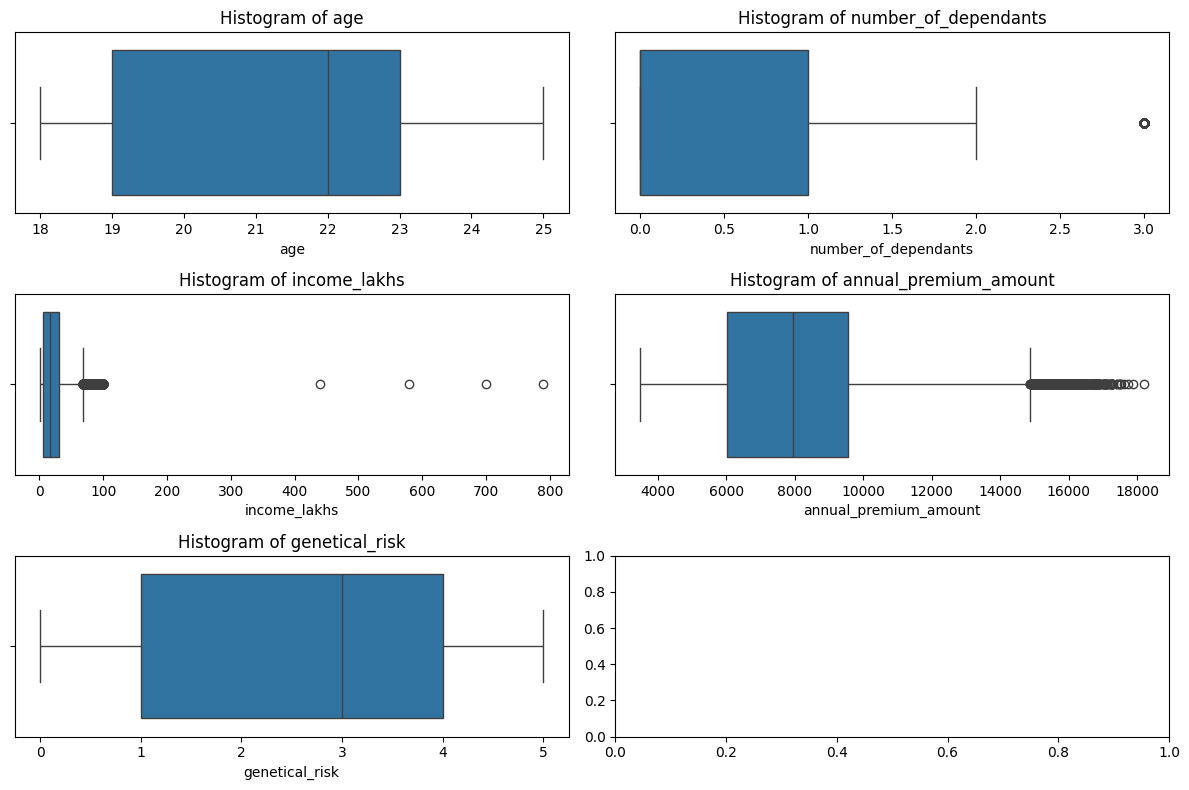

In [108]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for i, col in enumerate(numeric_columns):
    sns.boxplot(df, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')  # Set title for each plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [109]:
df[df['age'] > 100].shape

(0, 14)

In [110]:
df[df['age'] > 100]['age'].unique()

array([], dtype=int64)

In [111]:
df_new = df[df['age'] <= 100].copy()
df_new.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


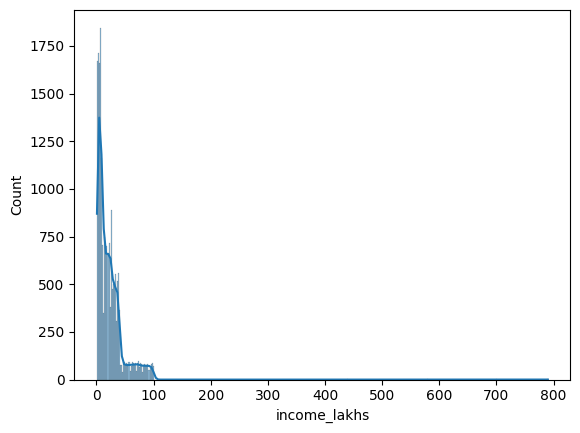

In [112]:
sns.histplot(df_new, x='income_lakhs', kde=True)
plt.show()

In [113]:
def get_iqr_bounds(col):
    q1, q3 = df_new[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

get_iqr_bounds('income_lakhs')

(-31.5, 68.5)

In [114]:
quantile_threshold = df_new['income_lakhs'].quantile(0.999)
df_new2 = df_new[df_new['income_lakhs'] <= quantile_threshold].copy()
df_new2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


#### Exploratory Data Analysis and Preparation

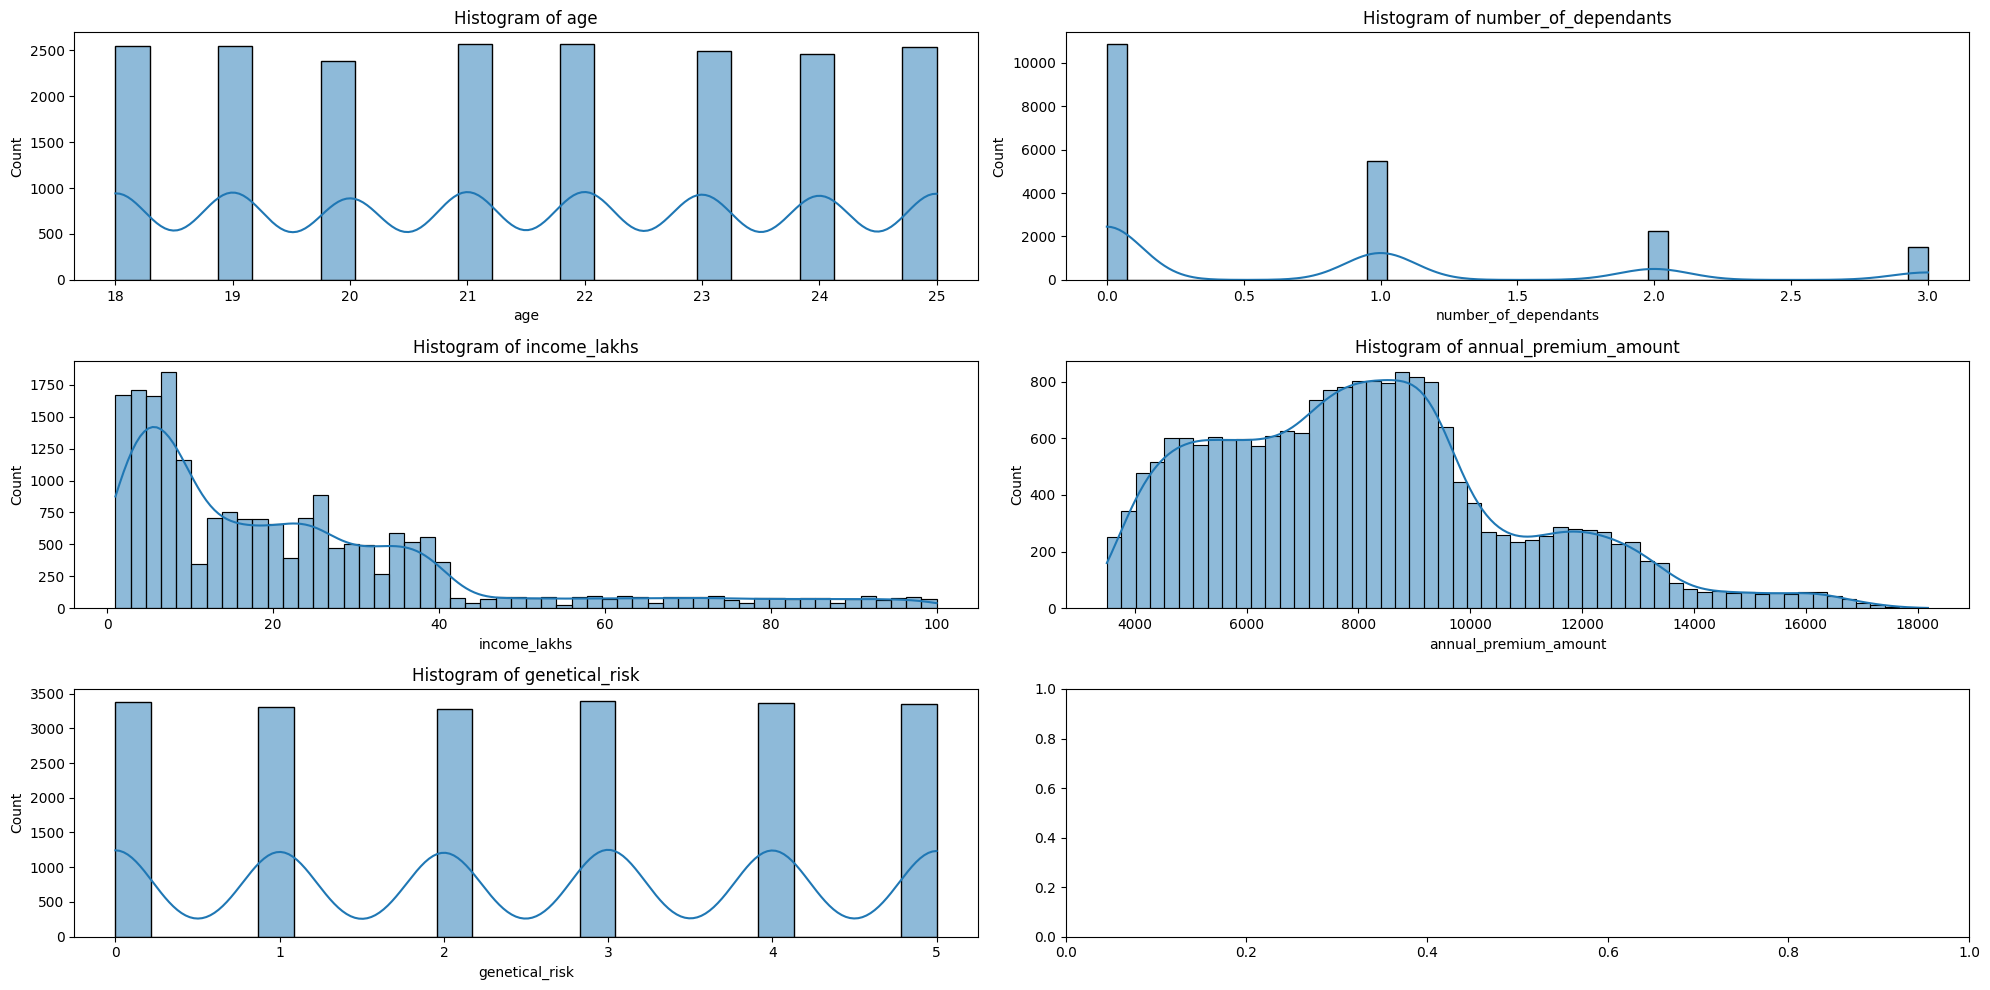

In [115]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for i, col in enumerate(numeric_columns):
    sns.histplot(df_new2, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')  # Set title for each plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

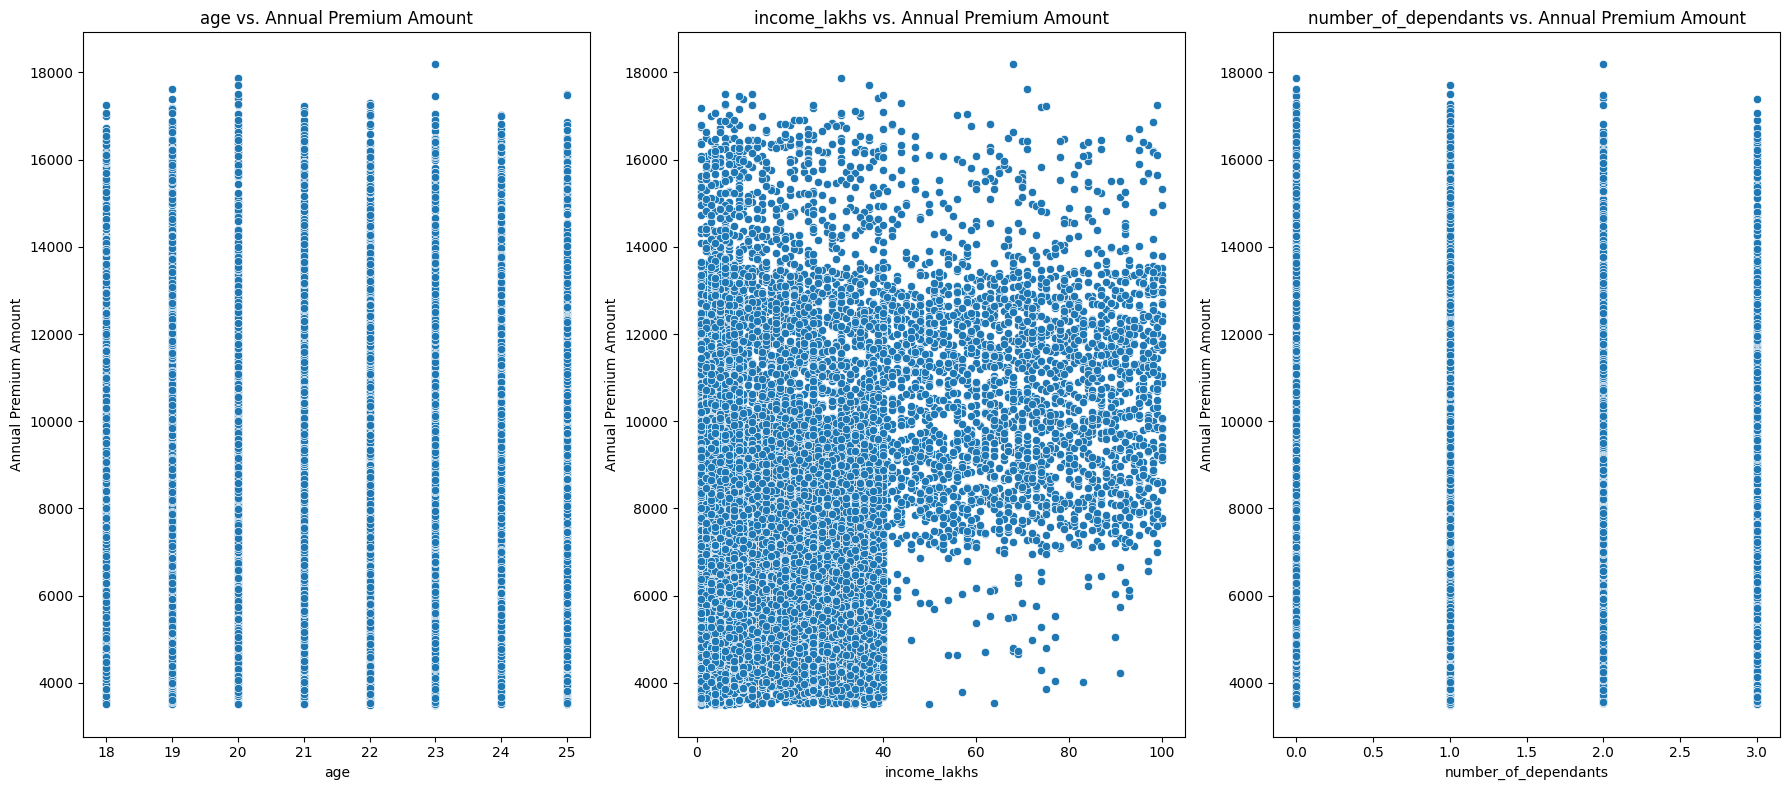

In [116]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 8))

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(df_new2, x=column, y='annual_premium_amount', ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [117]:
categorical_cols = df.select_dtypes('object').columns
for col in categorical_cols:
    print(col, ":", df_new[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [118]:
# Treating inconsistent values
df_new['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df_new['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

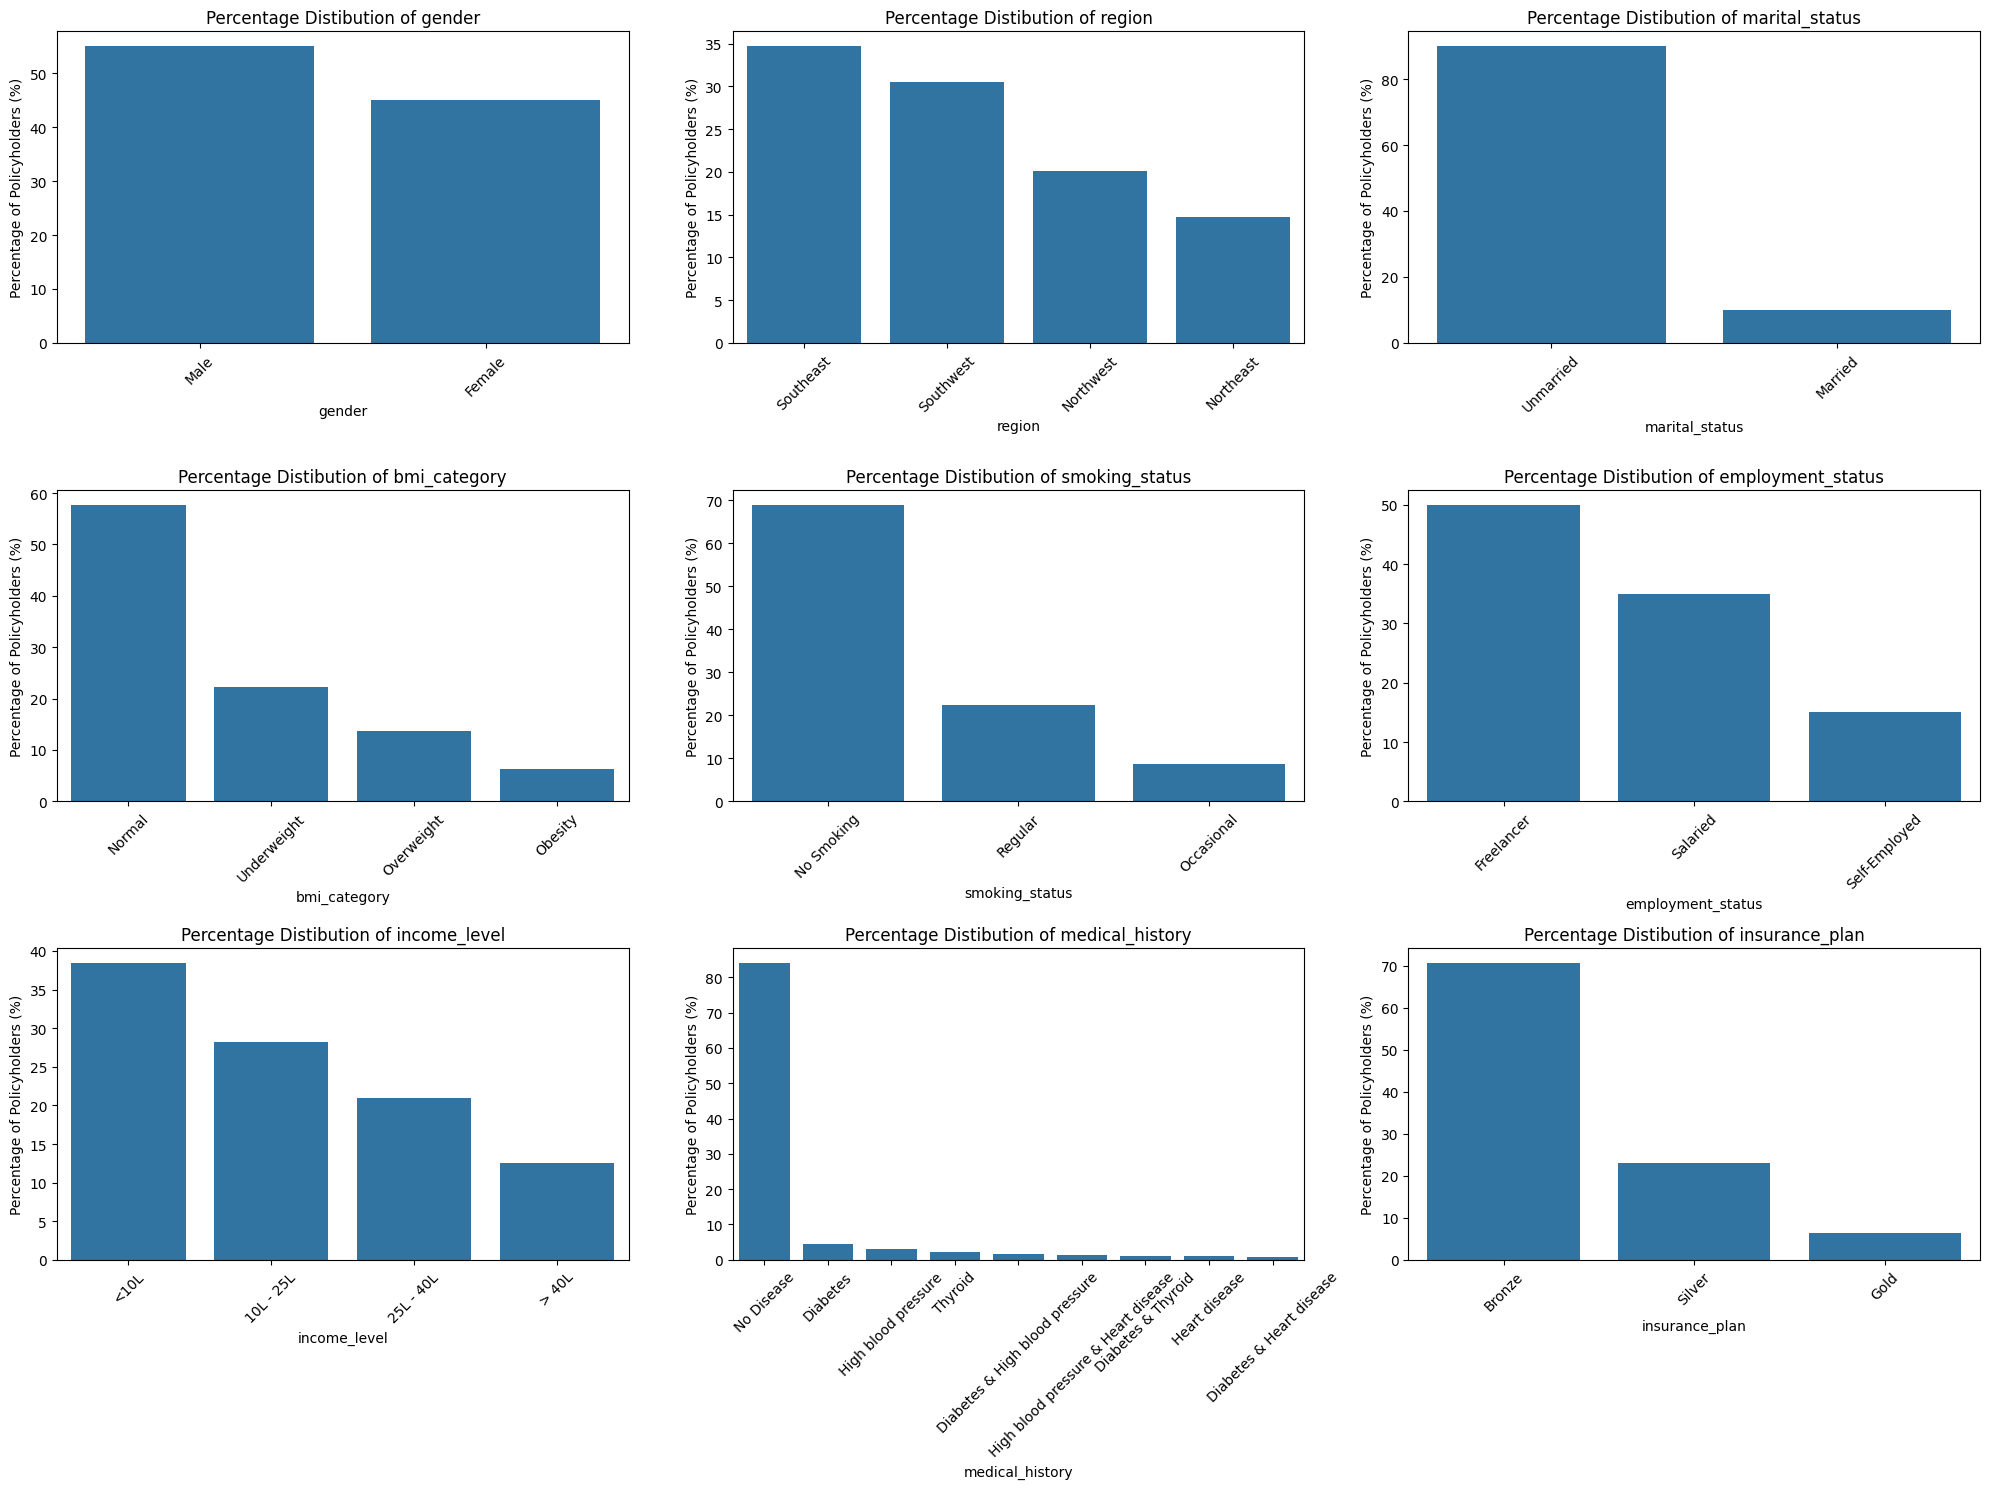

In [119]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for ax, col in zip(axes,categorical_cols):
    cat_count = df_new[col].value_counts(normalize=True) * 100
    sns.barplot(x=cat_count.index, y=cat_count.values, ax=ax)
    ax.set_title(f'Percentage Distibution of {col}')  # Set title for each plot
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

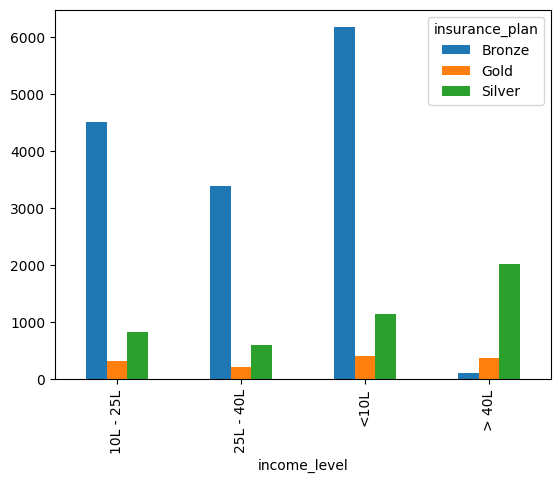

In [120]:
crosstab = pd.crosstab(df_new['income_level'], df_new['insurance_plan'])
crosstab.plot(kind='bar')
plt.show()

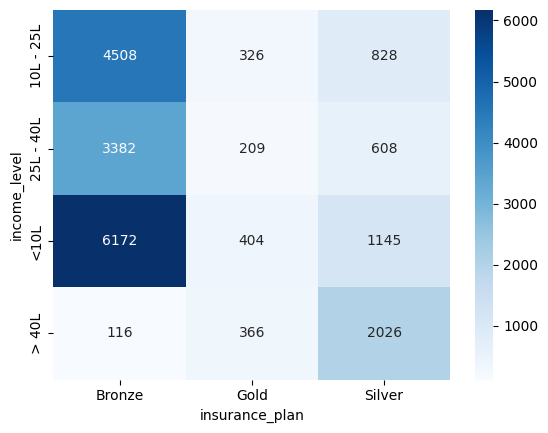

In [121]:
sns.heatmap(crosstab, fmt='d', cmap='Blues', annot=True)
plt.show()

#### Feature Engineering

In [122]:
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [123]:
df_new['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [124]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df_new[['disease1', 'disease2']] = df_new['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,None


In [125]:
df_new['disease1'].fillna('none', inplace=True)
df_new['disease2'].fillna('none', inplace=True)
df_new['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df_new['total_risk_score'] += df_new[disease].map(risk_scores)

max_score = df_new  ['total_risk_score'].max()
min_score = df_new['total_risk_score'].min()
df_new['normalized_risk_score'] = (df_new['total_risk_score'] - min_score) / (max_score - min_score)
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,none,0,0.000000


In [126]:
df_new['insurance_plan'] = df_new['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df_new['insurance_plan'].unique()

array([2, 1, 3], dtype=int64)

In [127]:
df_new['income_level'] = df_new['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})
df_new['income_level'].unique()

array([4, 1, 2, 3], dtype=int64)

In [128]:
df_new['bmi_category'] = df_new['bmi_category'].map({'Underweight': 1, 'Normal': 2, 'Overweight': 3, 'Obesity': 4})
df_new['bmi_category'].unique()

array([3, 1, 2, 4], dtype=int64)

In [129]:
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']
df_new3 = pd.get_dummies(df_new, columns=nominal_cols, drop_first=True, dtype=int)
df_new3.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,High blood pressure,2,13365,4,high blood pressure,...,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,No Disease,2,11050,3,no disease,...,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,No Disease,2,11857,4,no disease,...,0.000000,0,0,1,0,1,0,1,1,0
3,25,0,2,2,15,No Disease,1,5684,2,no disease,...,0.000000,1,0,1,0,1,0,0,0,0
4,20,2,3,2,14,No Disease,1,5712,1,no disease,...,0.000000,1,0,1,0,1,0,0,0,0


In [130]:
df_new4 = df_new3.drop(['disease1', 'disease2', 'medical_history', 'total_risk_score'], axis=1)
df_new4.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,2,11857,4,0.000000,0,0,1,0,1,0,1,1,0
3,25,0,2,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0
4,20,2,3,2,14,1,5712,1,0.000000,1,0,1,0,1,0,0,0,0


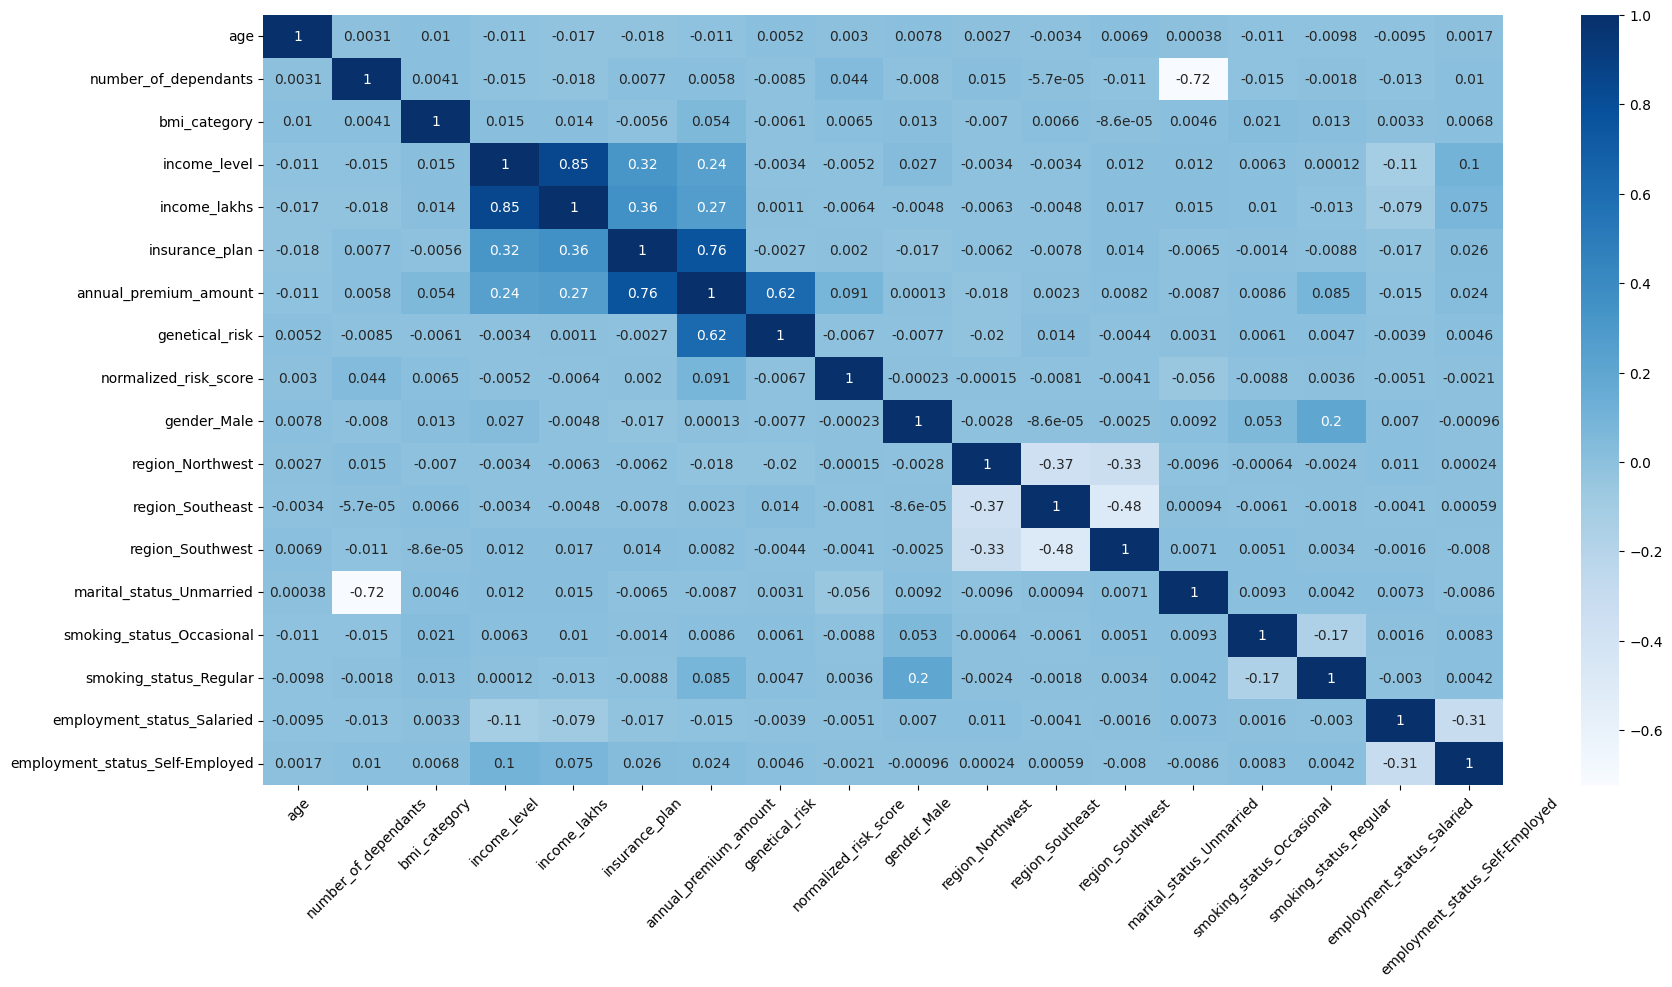

In [131]:
cm = df_new4.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xticks(rotation=45)
plt.show()

In [132]:
X = df_new4.drop(['annual_premium_amount'], axis=1)
y = df_new4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants', 'income_lakhs', 'income_level', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

def calculate_vif(data):
    df_vif = pd.DataFrame()
    df_vif['Variables'] = data.columns
    df_vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return df_vif

calculate_vif(X)

,Variables,VIF
0,age,3.176263
1,number_of_dependants,2.105609
2,bmi_category,6.822307
3,income_level,7.600070
4,income_lakhs,6.934923
5,insurance_plan,1.556745
6,genetical_risk,2.994340
7,normalized_risk_score,1.156302
8,gender_Male,2.304684
9,region_Northwest,2.175918


#### Model Training

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
print('Train score: ', train_score, 'Test score: ', test_score)

Train score:  0.9855653994284793 Test score:  0.9853388507894594


In [134]:
lr_model.intercept_

3710.020778755621

In [135]:
lr_model.coef_

array([-7.55086971e+00,  3.86811415e+00,  2.11274200e+02,  1.23425335e+01,
       -1.28255141e+02,  6.99478125e+03,  4.99630336e+03,  1.09970184e+03,
       -1.40855400e+01,  6.43050006e+00,  1.15682644e+01,  1.55452879e+01,
       -1.10038109e+01,  2.05338889e+02,  5.96035142e+02, -2.24008315e+00,
       -2.84904509e+00])

In [136]:
feature_importances = lr_model.coef_
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
income_lakhs,-128.255141
gender_Male,-14.085540
marital_status_Unmarried,-11.003811
age,-7.550870
employment_status_Self-Employed,-2.849045
employment_status_Salaried,-2.240083
number_of_dependants,3.868114
region_Northwest,6.430500
region_Southeast,11.568264
income_level,12.342533


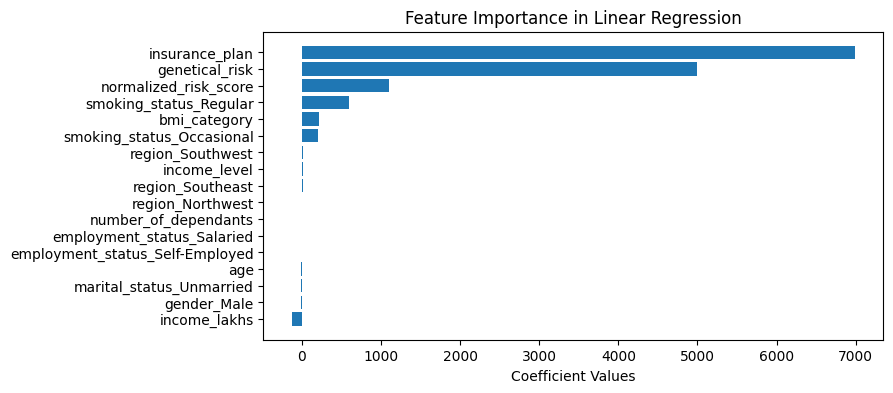

In [137]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'],)
plt.xlabel('Coefficient Values')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [138]:
rg_model = Ridge()
rg_model.fit(X_train, y_train)
train_score_rg = rg_model.score(X_train, y_train)
test_score_rg = rg_model.score(X_test, y_test)
print('Train score: ', train_score_rg, 'Test score: ', test_score_rg)

Train score:  0.9855647706528601 Test score:  0.9853347980086773


In [139]:
ls_model = Lasso()
ls_model.fit(X_train, y_train)
train_score_ls = ls_model.score(X_train, y_train)
test_score_ls = ls_model.score(X_test, y_test)
print('Train score: ', train_score_ls, 'Test score: ', test_score_ls)

Train score:  0.9855504919499417 Test score:  0.985326374728892


In [140]:
# xg_model = XGBRegressor()
# xg_model.fit(X_train, y_train)
# train_score_xg = xg_model.score(X_train, y_train)
# test_score_xg = xg_model.score(X_test, y_test)
# print('Train score: ', train_score_xg, 'Test score: ', test_score_xg)

In [141]:
# param_grid = {
#     'n_estimators': [20, 40, 50],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }

# rand_search = RandomizedSearchCV(xg_model, param_grid, cv=3, n_iter=10, scoring='r2', random_state=42)
# rand_search.fit(X_train, y_train)
# print(rand_search.best_score_)
# print(rand_search.best_params_)

In [142]:
best_model = lr_model
best_model

LinearRegression()

In [143]:
# feature_importances = best_model.feature_importances_

# coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
# coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
# # coef_df

# plt.figure(figsize=(8, 4))
# plt.barh(coef_df.index, coef_df['Coefficients'],)
# plt.xlabel('Coefficient Values')
# plt.title('Feature Importance in XGBoost Regressor')
# plt.show()

#### Error Analysis

In [144]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

result_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

result_df.head()

,actual,predicted,diff,diff_pct
8904,8679,8790.713242,111.713242,1.287167
2813,7847,7900.840460,53.840460,0.686128
1607,5210,5699.090082,489.090082,9.387526
10604,4103,4125.677684,22.677684,0.552710
19851,7562,7711.902204,149.902204,1.982309


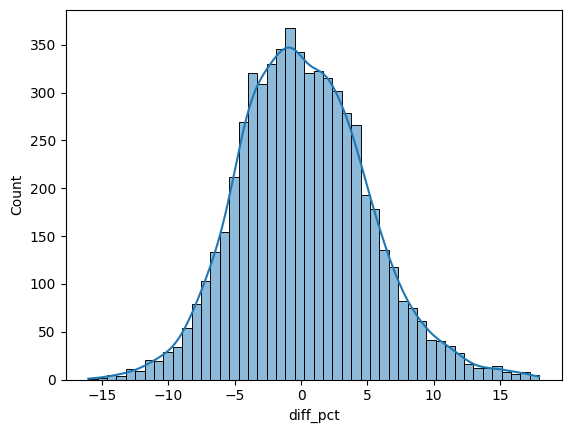

In [145]:
sns.histplot(result_df['diff_pct'], kde=True)
plt.show()

In [146]:
extreme_error_threshold = 10
extreme_result_df = result_df[abs(result_df['diff_pct']) > extreme_error_threshold]


In [147]:
extreme_error_pct = extreme_result_df.shape[0] * 100 / result_df.shape[0]
extreme_error_pct

4.562800730048116

In [148]:
result_df[abs(result_df['diff_pct']) > 50].sort_values(by='diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [149]:
extreme_error_df = X_test.loc[extreme_result_df.index]
extreme_error_df.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12058,0.714286,0.000000,2,0.666667,0.032953,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0
14463,0.857143,0.333333,1,0.333333,0.029151,0.0,0.0,0.0,1,1,0,0,1,0,1,0,0
10442,0.428571,0.000000,2,0.000000,0.006337,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0
6704,0.714286,0.000000,2,0.000000,0.005070,0.0,0.0,0.0,0,0,0,1,1,0,1,1,0
19554,0.285714,0.000000,1,1.000000,0.078580,0.0,0.2,0.0,1,0,1,0,1,0,1,0,1


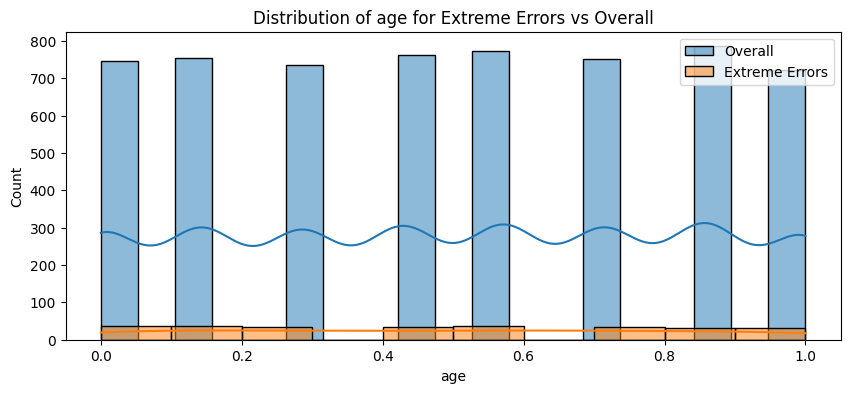

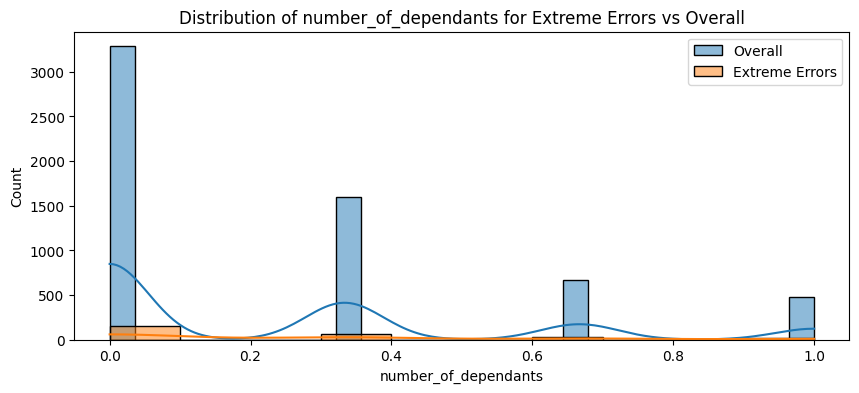

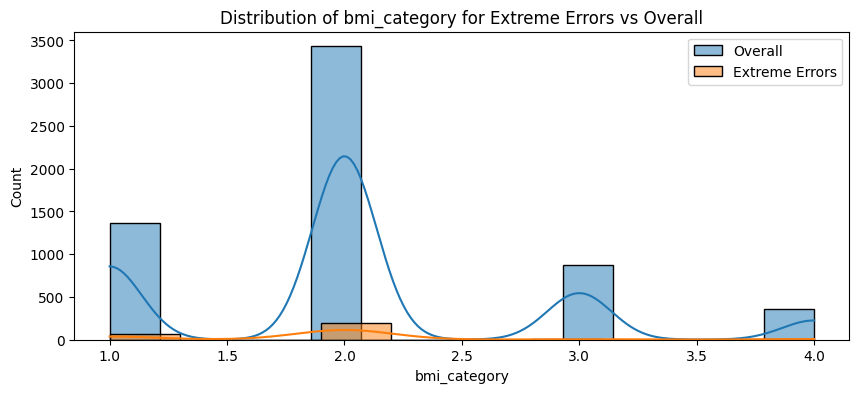

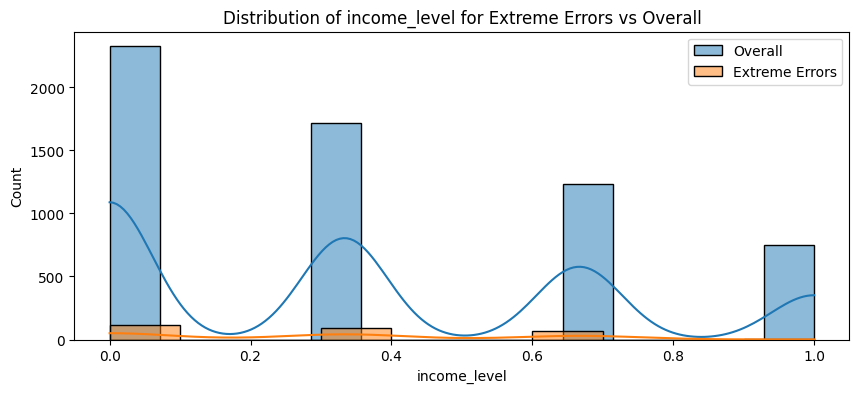

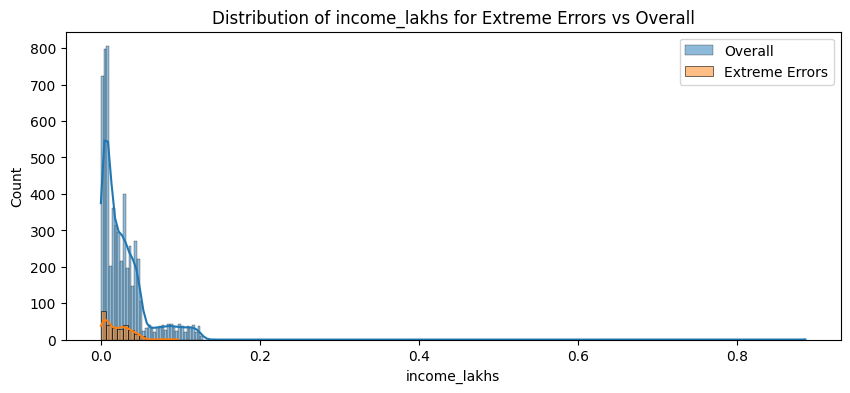

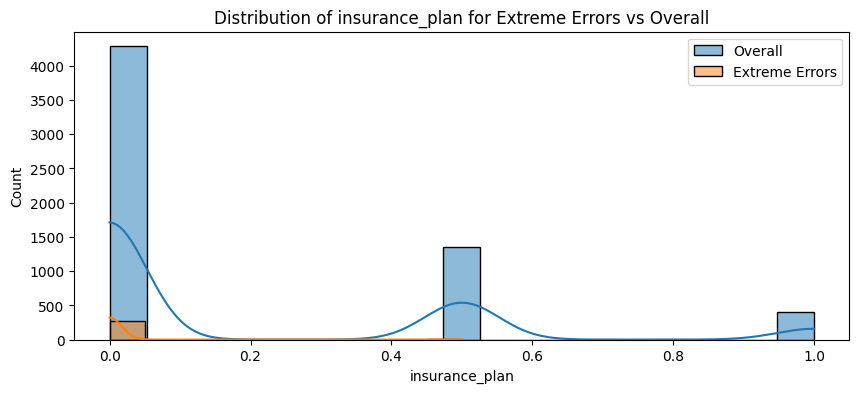

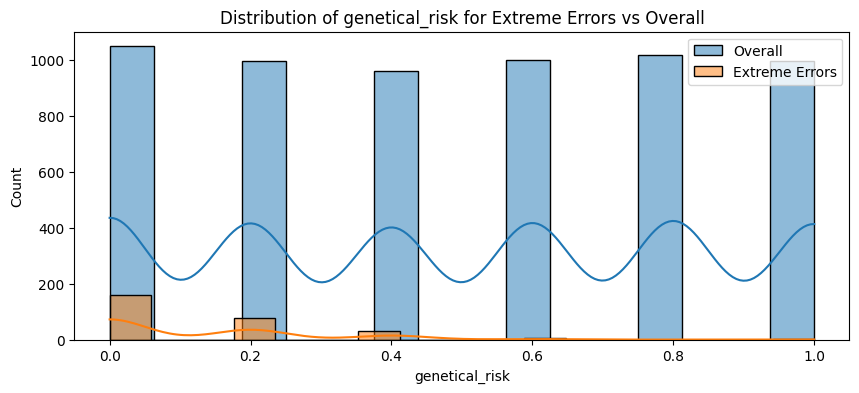

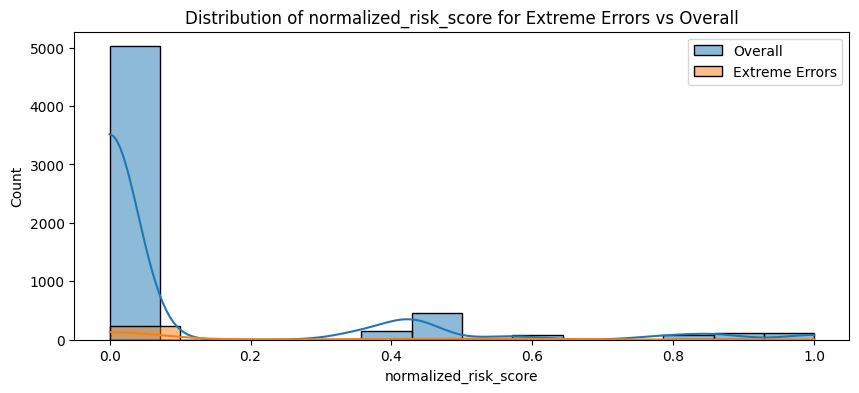

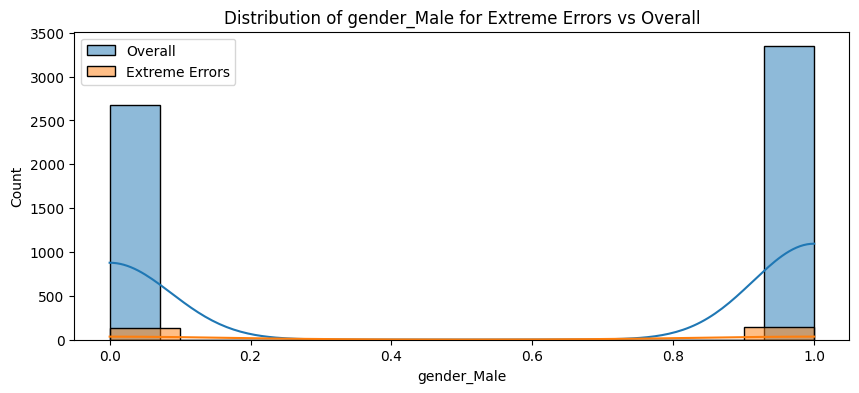

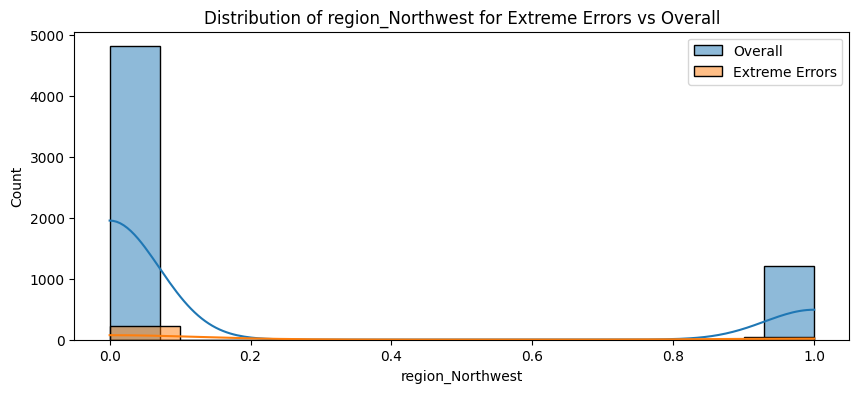

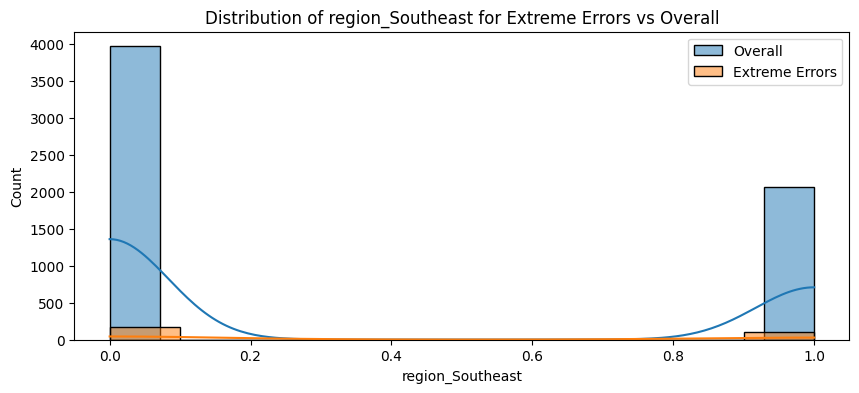

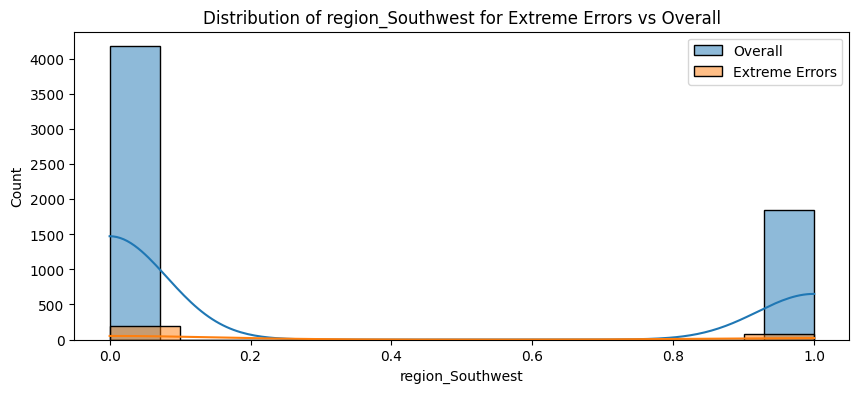

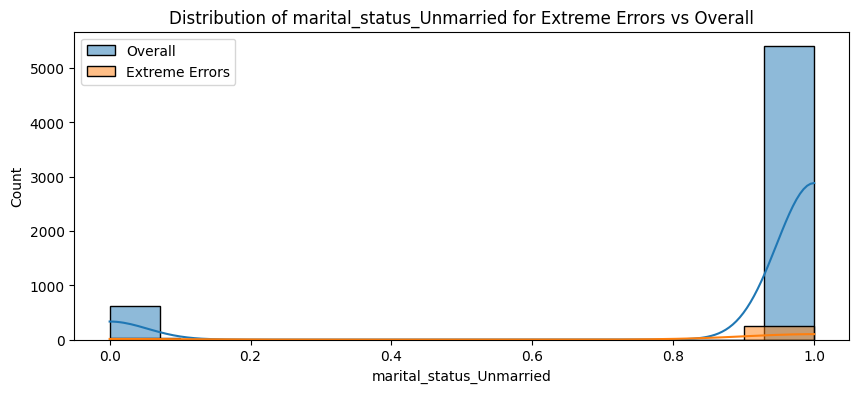

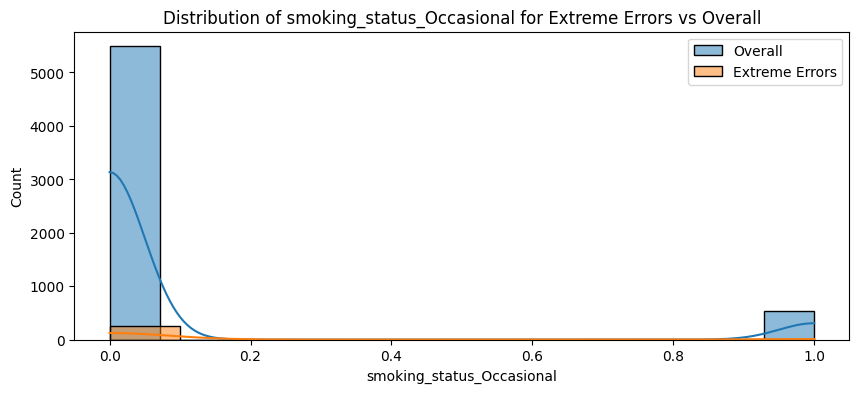

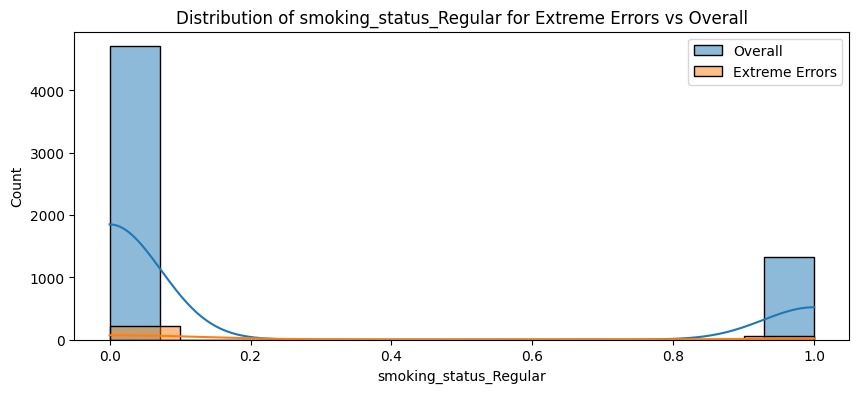

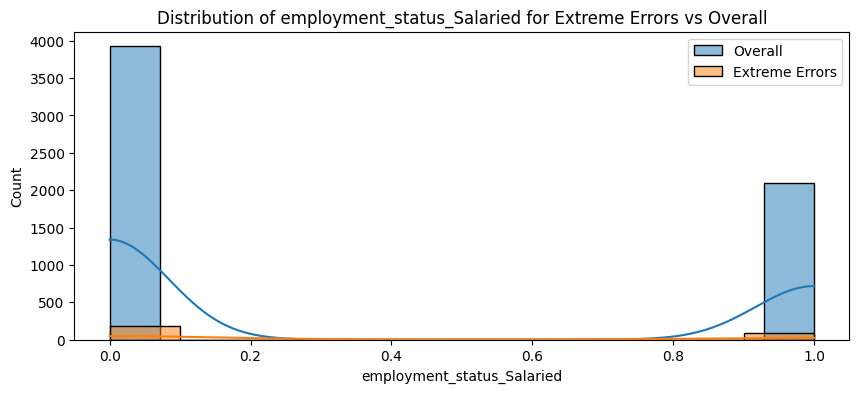

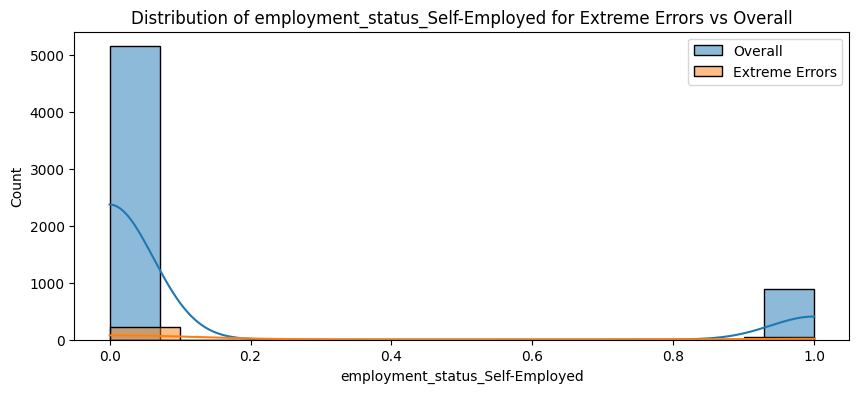

In [150]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], label='Overall', kde=True)
    sns.histplot(extreme_error_df[feature], label='Extreme Errors', alpha=0.5, kde=True)
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()

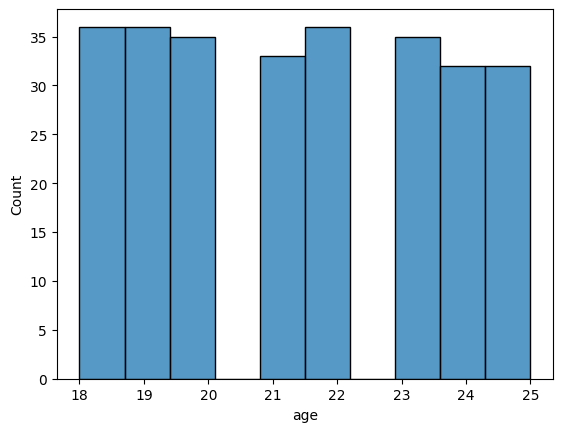

In [151]:
df_reversed = pd.DataFrame(scaler.inverse_transform(extreme_error_df[cols_to_scale]), columns=cols_to_scale)
original_age = df_reversed['age']
sns.histplot(original_age)
plt.show()

In [152]:
df_reversed.describe()

,age,number_of_dependants,income_lakhs,income_level,insurance_plan,genetical_risk
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,21.418182,0.727273,16.738182,1.850909,1.010909,0.578182
std,2.285234,0.960051,12.751005,0.821445,0.104065,0.799336
min,18.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,19.000000,0.000000,6.000000,1.000000,1.000000,0.000000
50%,21.000000,0.000000,15.000000,2.000000,1.000000,0.000000
75%,23.000000,1.000000,25.000000,2.500000,1.000000,1.000000
max,25.000000,3.000000,77.000000,4.000000,2.000000,5.000000


In [153]:
df_reversed['age'].quantile(0.97)

25.0

#### Exporting the Model

In [154]:
from joblib import dump
dump(best_model, 'artifacts/model_young.joblib')

['artifacts/model_young.joblib']

In [157]:
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, 'artifacts/scaler_young.joblib')

['artifacts/scaler_young.joblib']